# 

In [1]:
import pandas as pd
from utils import (
    compare_test_with_predicition,
    fit_model,
    get_parkings_df, 
    get_parkings_in_zone,
    get_hourly_parkings,
    get_pipeline,
    get_weather_data,
    add_seasonability_columns,
    print_metrics,
    SEASONABILITY_COLUMNS,
    RAIN,
    TEMPERATURE,
)

# Load and prepare data

In [2]:
df_parkings = get_parkings_df("../data/parkings_small.csv")
parkings_in_zone = get_parkings_in_zone(df_parkings, 1)
print(f"Found {len(parkings_in_zone)} parkings in zone")
hourly_parkings = get_hourly_parkings(parkings_in_zone)
hourly_parkings.head()
df_rain, df_temperature = get_weather_data()
hourly_parking = pd.merge(hourly_parkings, df_rain, on="ds", how='left')
hourly_parking = pd.merge(hourly_parking, df_temperature, on="ds", how='left')
hourly_parking.head()
df = hourly_parking.copy()
df.set_index("ds", inplace=True)
df.head()

Found 718955 parkings in zone


,num_parkings,rain,temperature
ds,,,
2024-05-07 13:00:00,0,False,9.8
2024-05-07 14:00:00,0,False,9.8
2024-05-07 15:00:00,0,False,9.2
2024-05-07 16:00:00,0,False,8.9
2024-05-07 17:00:00,0,False,8.2


#

mean squared error: 4942.30812396825
mean absolute percentage error 1019906045534940.2


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'month',
                                                   'dayofweek']),
                                                 ('Standard', StandardScaler(),
                                                  ['rain', 'temperature',
                                                   'year'])])),
                ('regressor', LinearRegression())])

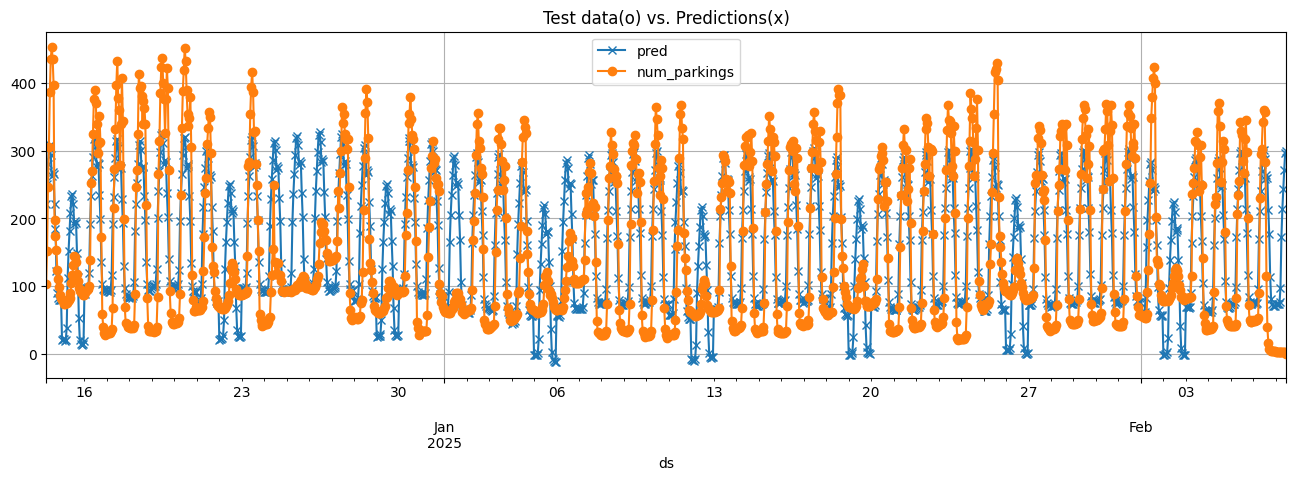

In [3]:
df = add_seasonability_columns(df)
pipeline = get_pipeline(SEASONABILITY_COLUMNS)
X_test, y_test = fit_model(pipeline, df, SEASONABILITY_COLUMNS+[RAIN, TEMPERATURE])
compare_test_with_predicition(pipeline, X_test, y_test)